<a href="https://colab.research.google.com/github/Ankam123niteesh/GenAI_2303A52341/blob/main/GenAI_object_detection_with_audio_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [2]:
!pip install opencv-python-headless

In [3]:
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=a2d33e203ae2fe1bf46e806c05032f5ddc159da09402e30bdd5e959d4502ce69
  Stored in directory: /root/.cache/pip/wheels/50/98/42/62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound


In [4]:
!pip install gtts

In [5]:
!pip install pyttsx3 pygame

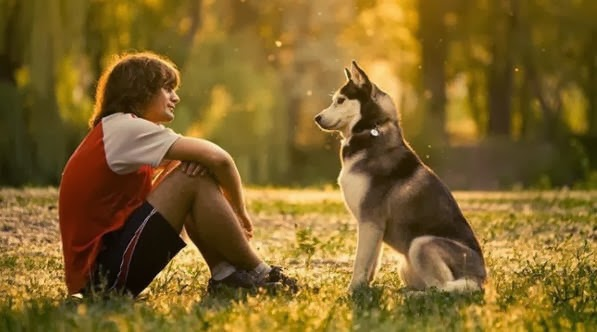

(332, 597, 3)


In [6]:
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import pandas as pd
import numpy as np
#image_path =cv2.imread("/content/1.jpg")
image_path =cv2.imread("/content/animals1.jpg")
#/content/drive/MyDrive/IMG-20240715-WA0000.jpg
cv2_imshow(image_path)
image_np = image_path
print(image_np.shape)
df = pd.DataFrame(image_np.reshape(-1, image_np.shape[-1]))
# print(df)


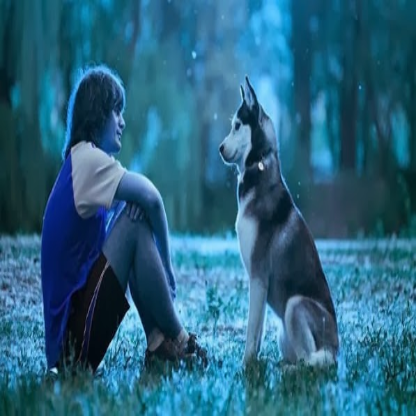

-1

In [11]:
import cv2
import numpy as np

# Load YOLOv3 model
#net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
classes = []
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load image
img = cv2.imread("/content/animals1.jpg")
height, width, channels = img.shape

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (416, 416))


# Preprocess image for YOLO
blob = cv2.dnn.blobFromImage(img_rgb, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Process detections
class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            # Bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates (top-left corner)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-max suppression to remove overlapping boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes and labels
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(len(classes), 3))

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 5), font, 1, color, 1)

# Display result
cv2_imshow(img_rgb)
cv2.waitKey(0)


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file âœ… 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 ðŸš€ 2025-4-24 Python-3.11.12 torch-2.6.0+cu124 CPU

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 14.1M/14.1M [00:00<00:00, 118MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 



Enter image path or URL:
/content/animals1.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


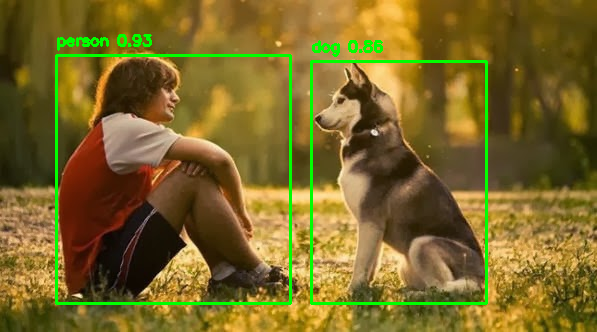


Detected 2 objects: person, dog

Output image saved as: detected_objects.jpg


In [10]:
import cv2
import torch
from gtts import gTTS
from playsound import playsound
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow


# Audio announcement function
def speak(text):
    tts = gTTS(text=text, lang='en')
    tts.save("output.mp3")

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def detect_objects(image_path):
    # Load image from path or URL
    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content))
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(image_path)

    # Perform detection
    results = model(img)
    detections = results.pandas().xyxy[0]

    # Process results
    detected_objects = []
    for _, det in detections.iterrows():
        if det['confidence'] > 0.5:
            detected_objects.append(det['name'])
            # Draw bounding box
            cv2.rectangle(img,
                        (int(det['xmin']), int(det['ymin'])),
                        (int(det['xmax']), int(det['ymax'])),
                        (0, 255, 0), 2)

            # Draw label
            cv2.putText(img, f"{det['name']} {det['confidence']:.2f}",
                      (int(det['xmin']), int(det['ymin']) - 10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Save and show output
    output_path = "detected_objects.jpg"
    cv2.imwrite(output_path, img)
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return list(set(detected_objects)), output_path

if __name__ == '__main__':
    # Get input from user
    print("\n\033[92mEnter image path or URL:\033[0m")
    image_input = input().strip()

    # Process detection
    objects, output_img = detect_objects(image_input)

    # Generate audio report
    if objects:
        announcement = f"Detected {len(objects)} objects: {', '.join(objects)}"
    else:
        announcement = "No objects detected"

    print(f"\n{announcement}")
    speak(announcement)

    print(f"\n\033[92mOutput image saved as: {output_img}\033[0m")

In [12]:
from google.colab import output
from IPython.display import Audio



Audio("/content/output.mp3", autoplay=True, rate=44100)  # 44100 is a common sample rate